# crypto_ml nootebook
Application using machine learning to predict cryptocurrency prices from Binance Exchange API.
App also allow to simulate trading based on predicted moves.


### Project design in form CRISP-DM metodology 
1. Business Understanding
2. Data Understanding
3. Data Preparation 
4. Modeling
5. Evaluation
6. Deployment

### Requirements
Requests - allows you to send HTTP/1.1 requests extremely easily. There’s no need to manually add query strings to your URLs, or to form-encode your POST data. Keep-alive and HTTP connection pooling are 100% automatic, thanks to urllib3.

https://docs.python-requests.org/en/master/

Pandas - open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

https://pandas.pydata.org/docs/

NumPy - the fundamental package for scientific computing in Python. It is a Python library that provides a multidimensional array object, various derived objects (such as masked arrays and matrices), and an assortment of routines for fast operations on arrays, including mathematical, logical, shape manipulation, sorting, selecting, I/O, discrete Fourier transforms, basic linear algebra, basic statistical operations, random simulation and much more.

https://numpy.org/doc/

Matplotlib - comprehensive library for creating static, animated, and interactive visualizations in Python.

https://matplotlib.org/

Scikit-learn - open source machine learning library that supports supervised and unsupervised learning. It also provides various tools for model fitting, data preprocessing, model selection and evaluation, and many other utilities.

https://scikit-learn.org/stable/index.html

In [1]:
# pip install requests 
# pip install pandas
# pip install numpy
# pip install matplotlib
# pip install sklearn

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

## 1. Business Understaning
Scenario: Let's assume we want to invest in cryptocurrencies. Our target is to build a model that will predict for us the next day price for the selected cryptocurrency. We also want to recieve information whether we should make a purchase or stay. 

To predict the price we will use linear regressions with machine learning. The data we use in our model will be taken from the public API provided by Binance Exchange https://github.com/binance/binance-spot-api-docs/blob/master/rest-api.md.

**Important ! The application should not be used for investing without proper knowledge of the cryptocurrency market and should only act as an auxiliary tool. You should also know that the cryptocurrency market is heavily manipulated (Elon Musk's tweets) and dependent on fear and greed (https://alternative.me/crypto/fear-and-greed-index/)**

## 2. Data Understanding

In [2]:
#Binance API URLs

# Binance API endpoint
api_base_endpoint = "https://api.binance.com"

# All current prices 
api_current_price = api_base_endpoint + "/api/v3/ticker/price"

# 1000 days with prices for BTCUSDT (limit - records limit(max-1000), symbol-crypto pair symbols, interval - time interval)
api_historical_price = api_base_endpoint + "/api/v3/klines?limit=1000&symbol=BTCUSDT&interval=1d"

In [3]:
#Use requests to get data from api as json
r_current_price = requests.get(api_current_price)
r_historical_price = requests.get(api_historical_price)

In [4]:
#Use pandas to read api with current prices
current_price = pd.read_json(r_current_price.text)

#Show all availabe pairs on Binance and thei prices (ETHBTC - ETH price in BTC)
current_price

,symbol,price
0,ETHBTC,0.076134
1,LTCBTC,0.006361
2,BNBBTC,0.011724
3,NEOBTC,0.001933
4,QTUMETH,0.005128
...,...,...
1440,DOGEBIDR,7214.270000
1441,ARBTC,0.000547
1442,ARBNB,0.047550
1443,ARBUSD,23.998000


In [5]:
#Use pandas to read api with historical prices selected pair
historical_price = pd.read_json(r_historical_price.text)

#Show all records for the selected pair and time interval
historical_price

,0,1,2,3,4,5,6,7,8,9,10,11
0,1534896000000,6479.98,6882.54,6251.20,6360.89,77909.391359,1534982399999,5.125012e+08,326562,40431.002002,2.662722e+08,0
1,1534982400000,6362.57,6576.99,6342.28,6525.01,40358.166825,1535068799999,2.597864e+08,187637,22134.603236,1.424921e+08,0
2,1535068800000,6525.00,6725.00,6440.50,6681.64,38305.675322,1535155199999,2.515131e+08,180167,21280.935824,1.397692e+08,0
3,1535155200000,6686.98,6789.00,6650.61,6733.64,19220.505929,1535241599999,1.290837e+08,122483,9829.849484,6.601930e+07,0
4,1535241600000,6733.64,6775.27,6568.00,6700.00,20107.297208,1535327999999,1.341179e+08,130769,9897.250377,6.604198e+07,0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,1620864000000,49537.15,51367.19,46000.00,49670.97,147332.002121,1620950399999,7.303695e+09,3570506,71742.003359,3.558735e+09,0
996,1620950400000,49671.92,51483.00,48799.75,49841.45,80082.204306,1621036799999,4.015905e+09,2095860,37184.128863,1.864163e+09,0
997,1621036800000,49844.16,50700.00,46555.00,46762.99,89437.449359,1621123199999,4.350776e+09,2286791,42257.918463,2.056303e+09,0
998,1621123200000,46762.99,49795.89,43825.39,46431.50,114269.812775,1621209599999,5.367498e+09,2661295,53797.590877,2.528671e+09,0


The data presented may be incomprehensible, but we have information about each column from the Binance documentation :

  **0**  1499040000000,      // Open time \
  **1**  "0.01634790",       // Open \
  **2**  "0.80000000",       // High \
  **3**  "0.01575800",       // Low \
  **4**  "0.01577100",       // Close \
  **5**  "148976.11427815",  // Volume \
  **6**  1499644799999,      // Close time \
  **7**  "2434.19055334",    // Quote asset volume \
  **8**  308,                // Number of trades \
  **9**  "1756.87402397",    // Taker buy base asset volume \
  **10** "28.46694368",      // Taker buy quote asset volume \
  **11** "17928899.62484339" // Ignore. \
  
In our model, we will only need columns in the range 0-5

## 2. Data Preparing

In [6]:
#Delete columns in the range 6-11
del_columns = historical_price.iloc[:,6:]
historical_price_df = historical_price.drop(del_columns, axis=1)

#Rename columns
historical_price_df = historical_price_df.rename(columns={0:'Open time', 1:'Open', 2:'High', 3:'Low', 4:'Close', 5:'Volume'})

#Change time from 'ns' to datetime 
historical_price_df['Open time'] = pd.to_datetime(historical_price_df['Open time'], unit="ms")

#Set time coulmn as index
historical_price_df = historical_price_df.set_index('Open time')

historical_price_df

,Open,High,Low,Close,Volume
Open time,,,,,
2018-08-22,6479.98,6882.54,6251.20,6360.89,77909.391359
2018-08-23,6362.57,6576.99,6342.28,6525.01,40358.166825
2018-08-24,6525.00,6725.00,6440.50,6681.64,38305.675322
2018-08-25,6686.98,6789.00,6650.61,6733.64,19220.505929
2018-08-26,6733.64,6775.27,6568.00,6700.00,20107.297208
...,...,...,...,...,...
2021-05-13,49537.15,51367.19,46000.00,49670.97,147332.002121
2021-05-14,49671.92,51483.00,48799.75,49841.45,80082.204306
2021-05-15,49844.16,50700.00,46555.00,46762.99,89437.449359


<AxesSubplot:xlabel='Open time'>

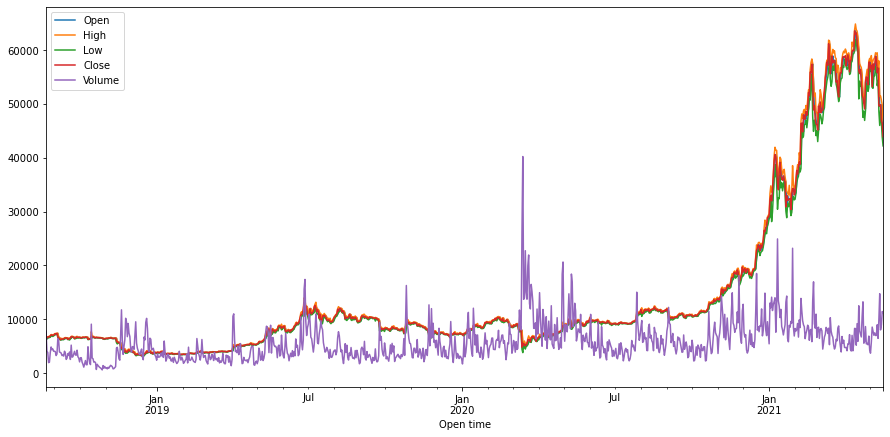

In [7]:
#Show how data looks on chart
plot_price = historical_price_df.copy()
plot_price['Volume'] = plot_price['Volume']/10 #Change Volume size to chart more readable 
plot_price.plot(figsize=(15,7))

### Linear regression 

**Hypothesis** 
$$ h_{\theta}(x_{m}) = \theta_{0} + \theta_{1}x_{1} + \theta_{2}x_{2} + ... + \theta_{n}x_{n}$$ \
$$y_{m} = next\_day\_price $$ \
$\;\;x_{n}$ - values \
$\;\;y$ - “output” variable/“target”'variable \
$\;\;n$ - number of features \
$\;\;m$ - number of days 

First model is inspired by https://blog.quantinsti.com/gold-price-prediction-using-machine-learning-python/

$$ h_{\theta}(x_{m}) = \theta_{0} + \theta_{1}x_{1} + \theta_{2}x_{2}$$ 

Where: \
$\;\;x_{1}$ - close mean value for 3 days \
$\;\;x_{2}$ - close mean value for 9 days \
$\;\;y$ - next day close price created from each next day record in our data (close column) 


Second model 
    $$ h_{\theta}(x_{m}) = \theta_{0} + \theta_{1}x_{1} + \theta_{2}x_{2} + \theta_{3}x_{3} + \theta_{4}x_{4}$$ \
Where: \
$\;\;x_{1}$ - Open price \
$\;\;x_{2}$ - Close price \
$\;\;x_{3}$ - Low price \
$\;\;x_{4}$ - Price price \
$\;\;y$ - next day mean price created from each next day mean price (open, close, low, high) record in our data

In [8]:
close_predict = historical_price_df.copy()

#close mean value for 3 days
close_predict['close_3'] = close_predict['Close'].rolling(window=3).mean()

#close mean value for 9 days 
close_predict['close_9'] = close_predict['Close'].rolling(window=9).mean()

#next day close price
close_predict['next_day_close_price'] = close_predict['Close'].shift(-1)

close_predict

,Open,High,Low,Close,Volume,close_3,close_9,next_day_close_price
Open time,,,,,,,,
2018-08-22,6479.98,6882.54,6251.20,6360.89,77909.391359,NaN,NaN,6525.01
2018-08-23,6362.57,6576.99,6342.28,6525.01,40358.166825,NaN,NaN,6681.64
2018-08-24,6525.00,6725.00,6440.50,6681.64,38305.675322,6522.513333,NaN,6733.64
2018-08-25,6686.98,6789.00,6650.61,6733.64,19220.505929,6646.763333,NaN,6700.00
2018-08-26,6733.64,6775.27,6568.00,6700.00,20107.297208,6705.093333,NaN,6908.64
...,...,...,...,...,...,...,...,...
2021-05-13,49537.15,51367.19,46000.00,49670.97,147332.002121,51990.770000,55559.542222,49841.45
2021-05-14,49671.92,51483.00,48799.75,49841.45,80082.204306,49714.580000,54715.691111,46762.99
2021-05-15,49844.16,50700.00,46555.00,46762.99,89437.449359,48758.470000,53645.614444,46431.50


In [9]:
#droping rows with NaN 
close_predict = close_predict.dropna()

close_predict

,Open,High,Low,Close,Volume,close_3,close_9,next_day_close_price
Open time,,,,,,,,
2018-08-30,7033.21,7063.63,6784.81,6984.84,44716.774620,7030.723333,6777.998889,7011.21
2018-08-31,6984.84,7089.00,6888.00,7011.21,40467.400638,7009.090000,6850.256667,7200.01
2018-09-01,7011.21,7275.00,7008.74,7200.01,40323.414093,7065.353333,6925.256667,7302.01
2018-09-02,7201.57,7345.45,7127.00,7302.01,39814.840352,7171.076667,6994.186667,7263.02
2018-09-03,7302.00,7338.28,7191.63,7263.02,32396.018371,7255.013333,7053.006667,7359.06
...,...,...,...,...,...,...,...,...
2021-05-12,56670.02,58000.01,48600.00,49631.32,99842.789836,54039.160000,55951.657778,49670.97
2021-05-13,49537.15,51367.19,46000.00,49670.97,147332.002121,51990.770000,55559.542222,49841.45
2021-05-14,49671.92,51483.00,48799.75,49841.45,80082.204306,49714.580000,54715.691111,46762.99


In [10]:
#copy historical prices without Volume column
mean_predict = historical_price_df[['Open', 'High', 'Low', 'Close']].copy()

#create column for mean value
mean_predict['mean'] = 0

#change he value in the column 'mean' to mean price of the Open, High, Low and Close records
for i in range(len(mean_predict)):
    mean_predict['mean'].iloc[i] = mean_predict.iloc[i,:4].mean()
    
#next day mean price
mean_predict['next_day_mean_price'] = mean_predict['mean'].shift(-1)

#droping rows with NaN 
mean_predict = mean_predict.dropna()

mean_predict  

C:\Users\Windows 10\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Open,High,Low,Close,mean,next_day_mean_price
Open time,,,,,,
2018-08-22,6479.98,6882.54,6251.20,6360.89,6493.6525,6451.7125
2018-08-23,6362.57,6576.99,6342.28,6525.01,6451.7125,6593.0350
2018-08-24,6525.00,6725.00,6440.50,6681.64,6593.0350,6715.0575
2018-08-25,6686.98,6789.00,6650.61,6733.64,6715.0575,6694.2275
2018-08-26,6733.64,6775.27,6568.00,6700.00,6694.2275,6798.9125
...,...,...,...,...,...,...
2021-05-12,56670.02,58000.01,48600.00,49631.32,53225.3375,49143.8275
2021-05-13,49537.15,51367.19,46000.00,49670.97,49143.8275,49949.0300
2021-05-14,49671.92,51483.00,48799.75,49841.45,49949.0300,48465.5375


## 3. Modeling
To create and evaluate the model we will use Sckit-learn library which will do all the linear regression calculations for us.
We will train two our models, compare them and choose a more exact onet.

Next day close price model:

In [11]:
#data
X = close_predict[['close_3', 'close_9']]

#target values
y = close_predict['next_day_close_price']

#split data 80% - training data; 20% - test data
split = 0.8
split = int(split*len(close_predict))

#training data
X_train = X[:split]
y_train = y[:split]

#test data
X_test = X[split:]
y_test = y[split:]

#import linear regression model from Scikit-learn
close_price_model = LinearRegression()

#fit linear model
close_price_model.fit(X_train, y_train)

LinearRegression()

In [12]:
#use model to predict test data
predicted_close_price = close_price_model.predict(X_test)

#create dataframe with predicted data
predicted_close_price_df = pd.DataFrame(predicted_close_price, index=y_test.index, columns=['Price'])
predicted_close_price_df

,Price
Open time,
2020-10-30,13448.576733
2020-10-31,13642.252634
2020-11-01,13745.585414
2020-11-02,13729.515429
2020-11-03,13798.573513
...,...
2021-05-12,53271.875477
2021-05-13,50840.480395
2021-05-14,48236.558358


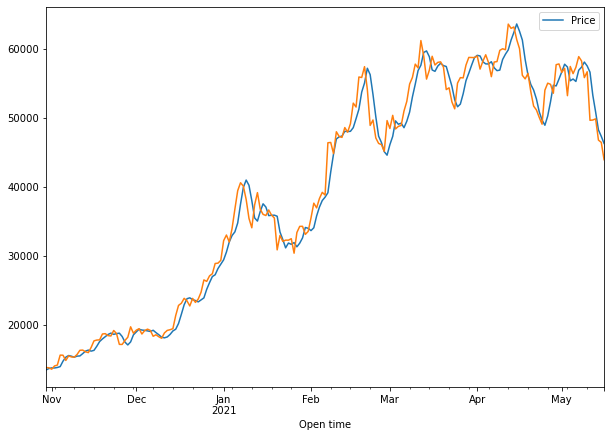

In [13]:
#plot dataframe with predicted data
predicted_close_price_df.plot(figsize=(10,7))
y_test.plot()
plt.show()

In [14]:
#return the coefficient of prediction
close_model_score = close_price_model.score(X[split:], y[split:])*100
print(f"Predict score: {float(close_model_score.round(2))} %")

print(f"Next day price h(x) = {close_price_model.intercept_.round(2)} + {close_price_model.coef_[0].round(2)} * 3 Days Moving Average (x1) \
+ {close_price_model.coef_[1].round(2)} * 9 Days Moving Average (x2)")

Predict score: 98.18 %
Next day price h(x) = 64.87 + 1.23 * 3 Days Moving Average (x1) + -0.24 * 9 Days Moving Average (x2)


Next day mean price model:

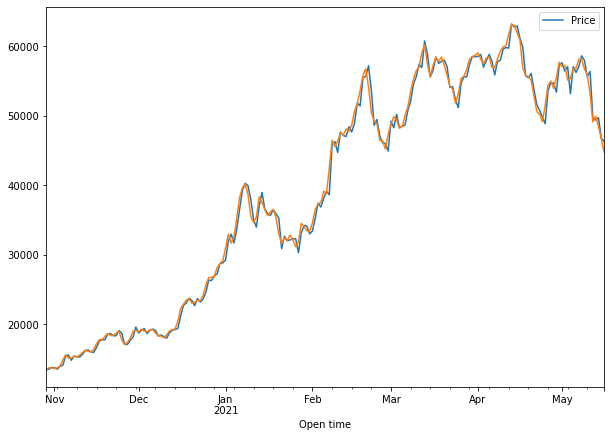

Predict score: 99.61 %
Next day price h(x) = 26.17 + -0.02 * Open price (x1) + 0.05 * High price (x2)  + 0.07 * Low price (x3) + 
+ 0.89 * Close price (x4)


In [15]:
X = mean_predict[['Open', 'High', 'Low', 'Close']]
y = mean_predict['next_day_mean_price']

split = 0.8
split = int(split*len(mean_predict))

X_train = X[:split]
y_train = y[:split]

X_test = X[split:]
y_test = y[split:]

mean_price_model = LinearRegression()
mean_price_model.fit(X_train, y_train)

predicted_mean_price = mean_price_model.predict(X_test)
predicted_mean_price_df = pd.DataFrame(predicted_mean_price, index=y_test.index, columns=['Price'])

predicted_mean_price_df.plot(figsize=(10,7))
y_test.plot()
plt.show()

mean_model_score = mean_price_model.score(X[split:], y[split:])*100
print(f"Predict score: {float(mean_model_score.round(2))} %" )

print(f"Next day price h(x) = {mean_price_model.intercept_.round(2)} + {mean_price_model.coef_[0].round(2)} * Open price (x1) \
+ {mean_price_model.coef_[1].round(2)} * High price (x2)  + {mean_price_model.coef_[2].round(2)} * Low price (x3) + \
\n+ {mean_price_model.coef_[3].round(2)} * Close price (x4)")

## 5. Evaluation

In [16]:
print(f"""Next day close price result: \n
Predict score: {float(close_model_score.round(2))} % \n
Next day price h(x) = {close_price_model.intercept_.round(2)} + {close_price_model.coef_[0].round(2)} * 3 Days Moving Average (x1) \n
+ {close_price_model.coef_[1].round(2)} * 9 Days Moving Average (x2) \n\n

Next day mean price result: \n
Predict score: {float(mean_model_score.round(2))} % \n
Next day price h(x) = {mean_price_model.intercept_.round(2)} + {mean_price_model.coef_[0].round(2)} * Open price (x1) \
+ {mean_price_model.coef_[1].round(2)} * High price (x2)  + {mean_price_model.coef_[2].round(2)} * Low price (x3) + \
{mean_price_model.coef_[3].round(2)} * Close price (x4) \n\n

Both models have very high predict score but first model predict only close price.
Due to possible large price changes in a given interval, we adopt a model predicting the next day mean price""")

Next day close price result: 

Predict score: 98.18 % 

Next day price h(x) = 64.87 + 1.23 * 3 Days Moving Average (x1) 

+ -0.24 * 9 Days Moving Average (x2) 



Next day mean price result: 

Predict score: 99.61 % 

Next day price h(x) = 26.17 + -0.02 * Open price (x1) + 0.05 * High price (x2)  + 0.07 * Low price (x3) + 0.89 * Close price (x4) 



Both models have very high predict score but first model predict only close price.
Due to possible large price changes in a given interval, we adopt a model predicting the next day mean price


## 6. Deployment

In [17]:
mean_predict_result = historical_price_df.copy()

mean_predict_result = mean_predict_result.iloc[:,0:4]
mean_predict_result['mean'] = 0

for i in range(len(mean_predict_result)):
    mean_predict_result['mean'].iloc[i] = mean_predict_result.iloc[i,:4].mean()
    
mean_predict_result['predicted_crypto_price'] = mean_price_model.predict(mean_predict_result[['Open', 'High', 'Low', 'Close']])
mean_predict_result

C:\Users\Windows 10\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Open,High,Low,Close,mean,predicted_crypto_price
Open time,,,,,,
2018-08-22,6479.98,6882.54,6251.20,6360.89,6493.6525,6385.326815
2018-08-23,6362.57,6576.99,6342.28,6525.01,6451.7125,6525.927194
2018-08-24,6525.00,6725.00,6440.50,6681.64,6593.0350,6677.381832
2018-08-25,6686.98,6789.00,6650.61,6733.64,6715.0575,6739.233313
2018-08-26,6733.64,6775.27,6568.00,6700.00,6694.2275,6701.634489
...,...,...,...,...,...,...
2021-05-13,49537.15,51367.19,46000.00,49670.97,49143.8275,49383.335428
2021-05-14,49671.92,51483.00,48799.75,49841.45,49949.0300,49741.490904
2021-05-15,49844.16,50700.00,46555.00,46762.99,48465.5375,46783.977390


In [18]:
mean_predict_result['move'] = np.where(
    mean_predict_result['mean'] < mean_predict_result['predicted_crypto_price'], "Buy", "Stay"
)
mean_predict_result.tail()

,Open,High,Low,Close,mean,predicted_crypto_price,move
Open time,,,,,,,
2021-05-13,49537.15,51367.19,46000.00,49670.97,49143.8275,49383.335428,Buy
2021-05-14,49671.92,51483.00,48799.75,49841.45,49949.0300,49741.490904,Stay
2021-05-15,49844.16,50700.00,46555.00,46762.99,48465.5375,46783.977390,Stay
2021-05-16,46762.99,49795.89,43825.39,46431.50,46703.9425,46302.680655,Stay
2021-05-17,46426.83,46686.00,42196.97,43918.87,44807.1675,43791.343262,Stay


In [19]:
def buys_simulator_df(df=mean_predict_result, money_buys=10):
    money_spend = 0
    buys = 0
    bought_coins = 0
    for i in range(len(df)):
        if df['move'].iloc[i] == 'Buy':
            buys +=1
            bought_coins += money_buys / df['mean'].iloc[i]
            money_spend += money_buys
    coin_price =df['mean'].iloc[-1]
    fortune = (bought_coins * coin_price).round(2)
    profit = (fortune - money_spend).round(2)
    rate_of_return = ((profit / money_spend) * 100).round(2)
    result_df = pd.DataFrame(data={
        'Money for buys': money_buys,
        'Buys number': buys,
        'Bought coins': bought_coins,
        'Money spend': money_spend,
        'Current coin price': coin_price,
        'Fortune': fortune,
        'profit': profit,
        'rate of return': rate_of_return,
    }, index=[0])
    return result_df

In [20]:
buys_simulator_df(money_buys = 100)

,Money for buys,Buys number,Bought coins,Money spend,Current coin price,Fortune,profit,rate of return
0,100,577,7.60497,57700,44807.1675,340757.15,283057.15,490.57


In [21]:
def buys_sales_simulator_df(df=mean_predict_result, money_buys=10, money_sales=10):
    money_spend = 0
    buys = 0
    bought_coins = 0
    sales = 0
    for i in range(len(df)):
        if df['move'].iloc[i] == 'Buy':
            buys +=1
            bought_coins += money_buys / df['mean'].iloc[i]
            money_spend += money_buys
        else:
            sales += 1
            bought_coins -= money_sales / df['mean'].iloc[i]
            money_spend -= money_sales 
    coin_price = df['mean'].iloc[-1]
    if bought_coins<0 or money_spend<0:
        return "Negative Values"
    fortune = (bought_coins * coin_price).round(2)
    profit = (fortune - money_spend).round(2)
    rate_of_return = ((profit / money_spend) * 100).round(2)
    result_df = pd.DataFrame(data={
        'Money for buys': money_buys,
        'Money for sales': money_sales,
        'Buys number': buys,
        'Sales number': sales,
        'Bought coins': bought_coins,
        'Money spend': money_spend,
        'Current coin price': coin_price,
        'Fortune': fortune,
        'profit': profit,
        'rate of return': rate_of_return,
    }, index=[0])
    return result_df

In [22]:
buys_sales_simulator_df()

,Money for buys,Money for sales,Buys number,Sales number,Bought coins,Money spend,Current coin price,Fortune,profit,rate of return
0,10,10,577,423,0.292719,1540,44807.1675,13115.9,11575.9,751.68
